## Import data and break in two segments

In [1]:
from fbprophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,ShuffleSplit,GridSearchCV
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import time
from datetime import timedelta, date
from fastai.tabular import *

%matplotlib inline

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
train_df = pd.read_csv('train.csv')
test_df =  pd.read_csv('test.csv')

In [4]:
train = pd.DataFrame(train_df.groupby(['application_date', 'segment'])['case_count'].sum())
train.reset_index(inplace=True)

In [5]:
train1_dates = train[train['segment']==1]['application_date']
train2_dates = train[train['segment']==2]['application_date']

In [6]:
train1 = train[train['segment']==1].reset_index(drop=True)
train2 = train[train['segment']==2].reset_index(drop=True)

test1 = test_df[test_df['segment']==1].reset_index(drop=True)
test2 = test_df[test_df['segment']==2].reset_index(drop=True)

test2 = test2.drop(['segment','id'], axis = 1)

## Train model for segment 1 using Facebook Prophet

In [7]:
train1 = train1.drop(['segment'],axis = 1)
train1.columns = ['ds','y']

In [8]:
train1['ds'] = pd.to_datetime(train1['ds'])
train1 = train1.set_index('ds')
train1 = train1.resample('D').asfreq()
train1 = train1.interpolate(method='polynomial', order=2)
train1.reset_index(inplace = True)

In [9]:
# upper_out = train1['y'][train1['y']>8000].index.values
# lower_out = train1['y'][train1['y']<50].index.values

# all_out = np.concatenate((upper_out,lower_out))
# train1.loc[all_out, 'y'] = None

In [10]:
fest_dussehra = pd.DataFrame({
                              'holiday': 'dussehra',
                              'ds': pd.to_datetime(['2017-09-30', '2018-10-19', '2019-10-8',])})

fest_chaturthia = pd.DataFrame({
                              'holiday': 'chaturthi',
                              'ds': pd.to_datetime(['2017-08-25', '2018-9-13', '2019-9-2',])})

fest_navrarti = pd.DataFrame({
                              'holiday': 'navrarti',
                              'ds': pd.to_datetime(['2017-9-21', '2017-9-22', '2017-9-23', '2017-9-24', '2017-9-25',
                                                    '2017-9-26', '2017-9-27', '2017-9-28', '2017-9-29', '2017-9-30', 
                                                    '2018-10-9', '2018-10-10', '2018-10-11', '2018-10-12', '2018-10-13',
                                                    '2018-10-14', '2018-10-15', '2018-10-16', '2018-10-17', '2018-10-18',
                                                    '2019-9-29', '2019-9-30', '2019-10-1', '2019-10-2', '2019-10-3',
                                                    '2019-10-4', '2019-10-5', '2019-10-6', '2019-10-7', '2019-10-8'])})

fest_raksabandan = pd.DataFrame({
                              'holiday': 'raksabandan',
                              'ds': pd.to_datetime(['2017-08-7', '2018-8-18', '2019-8-19',])})

fest_janmastmi = pd.DataFrame({
                              'holiday': 'janmastmi',
                              'ds': pd.to_datetime(['2017-08-14', '2018-9-2', '2019-8-24',])})

holidays = pd.concat((fest_dussehra, fest_chaturthia))
holidays = pd.concat((holidays, fest_navrarti))
holidays = pd.concat((holidays, fest_raksabandan))
holidays = pd.concat((holidays, fest_janmastmi))

In [11]:
def is_friday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6:
        return 1
    else:
        return 0
train1['is_friday'] = train1['ds'].apply(is_friday)
test1['is_friday'] = test1['application_date'].apply(is_friday)

In [12]:
m1 = Prophet(holidays = holidays)
# m1.add_seasonality(name='monthly', period=30.5, fourier_order=2)
# m1.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.7)
m1.add_regressor('is_friday')
m1.add_country_holidays(country_name='IN')
m1.fit(train1)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Program_Files\Anaconda3\lib\site-packages\fbprophet\hdays.py:256: Warning:

We only support Diwali and Holi holidays from 2010 to 2025



In [13]:
future1 = m1.make_future_dataframe(periods=test1.shape[0])
future1['is_friday'] = future1['ds'].apply(is_friday)

In [14]:
forecast1 = m1.predict(future1)

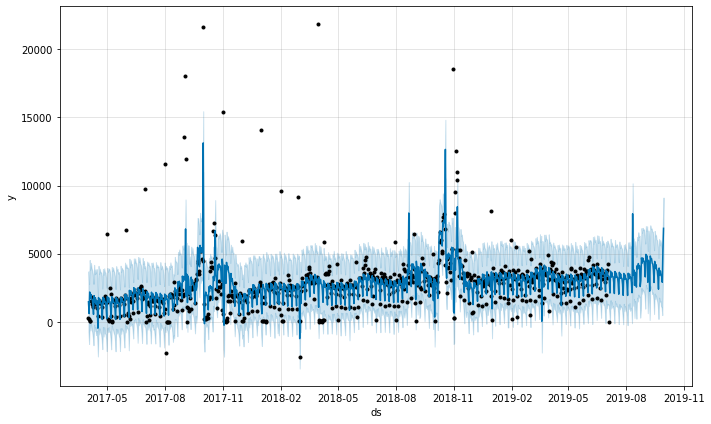

In [15]:
ax1 = m1.plot(forecast1)

In [16]:
# fig = m1.plot_components(forecast1)

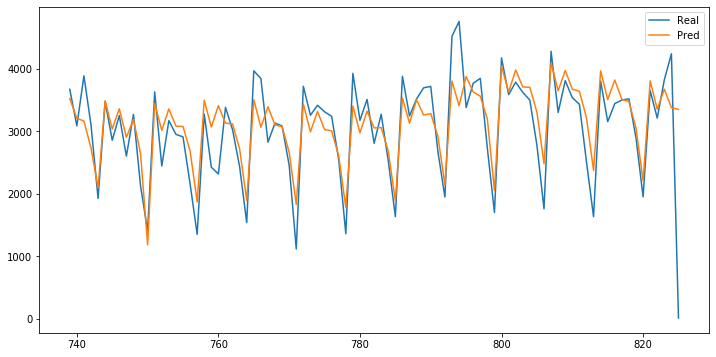

In [17]:
plt.figure(figsize = (12,6))
plt.plot(train1['y'][-87:], label = 'Real')
plt.plot(forecast1['yhat'][-(87+87):-87], label = 'Pred')
plt.legend()

In [18]:
mean_absolute_percentage_error(train1['y'][-87:-1],forecast1['yhat'][-(87+87):-88])

11.892146271840774

### meta-analysis of segment 1

In [19]:
forecast1['real'] = 0 
forecast1['real'].iloc[:-87] = train1['y'].values
check_df = forecast1[['ds','yhat', 'real']].iloc[:-87,:]
check_df = check_df.set_index('ds')

C:\Program_Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



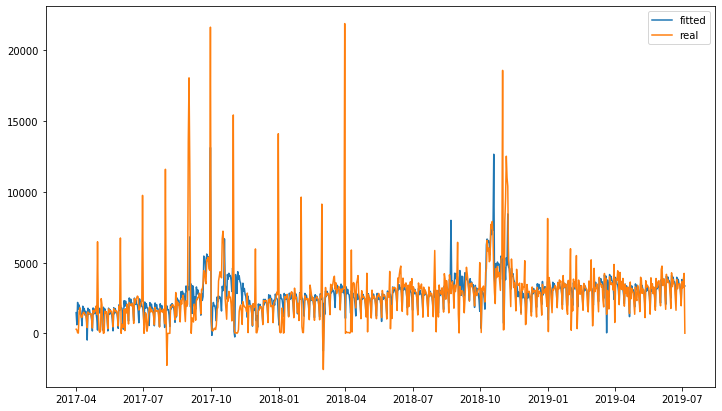

In [20]:
plt.figure(figsize = (12,7))
plt.plot(check_df['yhat'], label = 'fitted')
plt.plot(check_df['real'], label = 'real')
plt.legend()

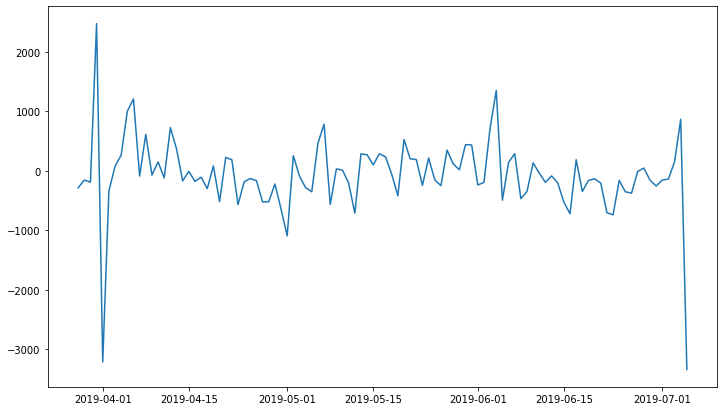

In [21]:
check_df['diff'] = check_df['real']-check_df['yhat']
plt.figure(figsize = (12,7))
plt.plot(check_df['diff'][-100:])

In [22]:
# #Post processing to add increased values at end of month
# forecast1['yhat'][forecast1['ds']=='2019-07-31'] = forecast1['yhat'][-87:-57].mean()*1.3
# forecast1['yhat'][forecast1['ds']=='2019-08-31'] = forecast1['yhat'][-57:-27].mean()*1.3
# forecast1['yhat'][forecast1['ds']=='2019-09-30'] = forecast1['yhat'][-27:].mean()*1.5

In [23]:
#Further inflate last values of September due to Navrarti
navrarti_2019 = ['2019-9-29']

forecast1['yhat'][forecast1['ds'].isin(navrarti_2019)] = forecast1['yhat'].iloc[-1]*0.7

C:\Program_Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
#Pump up Fridays 
for i in range(forecast1.shape[0]):
    if forecast1['ds'][i].weekday()==4:
        forecast1['yhat'][i] = forecast1['yhat'][i]*1.1

C:\Program_Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Train model for segment 2 using Boosted Trees

In [25]:
add_datepart(train2, 'application_date', drop = False)
add_cyclic_datepart(train2, 'application_date')

add_datepart(test2, 'application_date', drop = False)
add_cyclic_datepart(test2, 'application_date')

,application_Year,application_Month,application_Week,application_Day,application_Dayofweek,application_Dayofyear,application_Is_month_end,application_Is_month_start,application_Is_quarter_end,application_Is_quarter_start,...,application_Is_year_start,application_Elapsed,application_weekday_cos,application_weekday_sin,application_day_month_cos,application_day_month_sin,application_month_year_cos,application_month_year_sin,application_day_year_cos,application_day_year_sin
0,2019,7,30,24,2,205,False,False,False,False,...,False,1563926400,-0.222521,0.974928,-0.050649,-0.998717,-1.000000e+00,1.224647e-16,-0.932289,-0.361714
1,2019,7,30,25,3,206,False,False,False,False,...,False,1564012800,-0.900969,0.433884,0.151428,-0.988468,-1.000000e+00,1.224647e-16,-0.925925,-0.377708
2,2019,7,30,26,4,207,False,False,False,False,...,False,1564099200,-0.900969,-0.433884,0.347305,-0.937752,-1.000000e+00,1.224647e-16,-0.919286,-0.393590
3,2019,7,30,27,5,208,False,False,False,False,...,False,1564185600,-0.222521,-0.974928,0.528964,-0.848644,-1.000000e+00,1.224647e-16,-0.912375,-0.409356
4,2019,7,30,28,6,209,False,False,False,False,...,False,1564272000,0.623490,-0.781831,0.688967,-0.724793,-1.000000e+00,1.224647e-16,-0.905193,-0.425000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2019,10,42,20,6,293,False,False,False,False,...,False,1571529600,0.623490,-0.781831,-0.758758,-0.651372,-1.836970e-16,-1.000000e+00,0.309017,-0.951057
89,2019,10,43,21,0,294,False,False,False,False,...,False,1571616000,1.000000,0.000000,-0.612106,-0.790776,-1.836970e-16,-1.000000e+00,0.325342,-0.945596
90,2019,10,43,22,1,295,False,False,False,False,...,False,1571702400,0.623490,0.781831,-0.440394,-0.897805,-1.836970e-16,-1.000000e+00,0.341571,-0.939856
91,2019,10,43,23,2,296,False,False,False,False,...,False,1571788800,-0.222521,0.974928,-0.250653,-0.968077,-1.836970e-16,-1.000000e+00,0.357698,-0.933837


In [26]:
train2_x = train2.drop(['segment', 'case_count'],axis = 1)
train2_y = train2['case_count']

In [27]:
train2_x_early, valid2_x_early, train2_y_early, valid2_y_early = train_test_split(train2_x,train2_y,
                                                                                  test_size = 0.11, 
                                                                                  random_state = 1362,
                                                                                  shuffle = False)

In [28]:
def GradientBooster2(param_grid, n_jobs): 
    estimator = GradientBoostingRegressor() 
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state = 3344) 

    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs) 

    classifier.fit(train2_x, train2_y) 
 
    print(classifier.best_estimator_) 
    return cv, classifier.best_estimator_ 

param_grid={'n_estimators':[100, 120], 
            'learning_rate': [0.1],
            'max_depth':[8, 9],#4,6], 
            'min_samples_split': [3,5],
            'min_samples_leaf':[1,3],#,5,9,17], 
            'max_features':[0.8, 1.0],#,0.3]#,0.1]
            #'min_impurity_decrease':[1.0],
            
            'alpha':[0.8,0.9],
            'subsample': [0.9, 1.0],
            'criterion':['friedman_mse'], 
            'random_state': [365]
           } 

n_jobs=4 

cv2,best_est2 = GradientBooster2(param_grid, n_jobs)

GradientBoostingRegressor(alpha=0.8, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=9,
                          max_features=0.8, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='auto',
                          random_state=365, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [29]:
print("Best Estimator Parameters for Segment 2") 
print("---------------------------") 
print("n_estimators: %d" %best_est2.n_estimators) 
print("max_depth: %d" %best_est2.max_depth) 
print("Learning Rate: %.1f" %best_est2.learning_rate)
print("min_samples_split: %d" %best_est2.min_samples_split)
print("min_samples_leaf: %d" %best_est2.min_samples_leaf) 
print("max_features: %.1f" %best_est2.max_features) 
print("subsample: %.1f" %best_est2.subsample) 

Best Estimator Parameters for Segment 2
---------------------------
n_estimators: 120
max_depth: 9
Learning Rate: 0.1
min_samples_split: 3
min_samples_leaf: 3
max_features: 0.8
subsample: 0.9


In [30]:
train2_pred_early = best_est2.predict(train2_x_early)
train2_pred_valid = best_est2.predict(valid2_x_early)

In [31]:
mape_train2 = mean_absolute_percentage_error(train2_y_early,train2_pred_early)
mape_valid2 = mean_absolute_percentage_error(valid2_y_early,train2_pred_valid)

print('Train2 mape: {}'.format(mape_train2))
print('Valid2 mape: {}'.format(mape_valid2))

Train2 mape: 0.8809561849466553
Valid2 mape: 0.8064024732106804


In [32]:
test2_pred = best_est2.predict(test2)

In [33]:
sub = pd.read_csv('sample_submission.csv')

sub['case_count'][sub['segment']==1] = forecast1['yhat'][-87:].values
sub['case_count'][sub['segment']==2] = test2_pred

sub.to_csv('mix1156_3.csv',index = False)

C:\Program_Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Program_Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

